<a href="https://colab.research.google.com/github/Catalystde/Variational_autoEncoders/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

#Data Preparation

In [2]:
(x_train,_),(x_test,_) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train,x_test],axis=0)
mnist_digits = np.expand_dims(mnist_digits,-1).astype('float32')/255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
mnist_digits.shape

(70000, 28, 28, 1)

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [5]:
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

In [6]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [7]:
train_dataset = (
                  dataset
                 .shuffle(buffer_size=1024,reshuffle_each_iteration=True)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE)
                 )

In [8]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#Modeling

##Sampling

In [9]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

##Encoder

In [10]:
encoder_inputs = Input(shape=(28,28,1))
x = Conv2D(32,3,strides=2,activation='relu',padding='same')(encoder_inputs)
x = Conv2D(64,3,strides=2,activation='relu',padding='same')(x)
x = Flatten()(x)
x = Dense(16,activation='relu')(x)

mean = Dense(LATENT_DIM,name='z_mean')(x)
log_var = Dense(LATENT_DIM,name='z_log_var')(x)

z = Sampling()([mean,log_var])
encoder = Model(encoder_inputs,[z,mean,log_var],name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

##Decoder

In [11]:
latent_inputs = Input(shape=(LATENT_DIM,))
x = Dense(7*7*64,activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64,3,strides=2,padding='same',activation='relu')(x)
x = Conv2DTranspose(32,3,strides=2,padding='same',activation='relu')(x)
decoder_outputs = Conv2DTranspose(1,3,padding='same',activation='sigmoid')(x)
decoder = Model(latent_inputs,decoder_outputs,name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

#Overall VAE Model

In [12]:
vae_inputs = Input(shape=(28,28,1))
z,_,_ = encoder(vae_inputs)
output = decoder(z)
vae = Model(vae_inputs,output,name='vae')
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

#Training

In [13]:
OPTIMIZER = Adam(learning_rate=1e-3)
EPOCHS = 30

In [14]:
def custom_loss(y_true,Y_pred,mean,log_var):
    loss_recons = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,Y_pred),axis=(1,2)))
    loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(1+log_var-tf.square(mean)-tf.exp(log_var)),axis=1))
    return loss_recons + loss_reg

In [15]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder(x_batch)
    y_pred = decoder(z)
    y_true = x_batch
    loss = custom_loss(y_true,y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss


In [16]:
def ankitmodel(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')



In [17]:
ankitmodel(EPOCHS)

Training starts for epoch number 1
Training Loss is:  tf.Tensor(181.21948, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(170.6608, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(168.09196, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(154.46745, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(159.81625, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is:  tf.Tensor(152.70616, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is:  tf.Tensor(149.7109, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is:  tf.Tensor(151.0832, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is:  tf.Tensor(138.51372, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is:  tf.Tensor(149.97745, shape=(), dtype=float32)
Tr

#Testing

In [18]:
scale = 1
n=16

In [19]:
grid_x = np.linspace(-scale,scale,n)
grid_y = np.linspace(-scale,scale,n)

In [20]:
print(grid_x)
print(grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]
[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

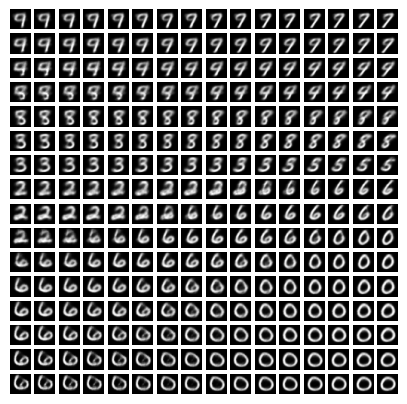

In [21]:
plt.figure(figsize=(5,5))
k=0
for i in grid_x:
  for j in grid_y:
    ax = plt.subplot(n,n,k+1)
    input = tf.constant([[i,j]])
    out = vae.layers[2].predict(input)[0][...,0]
    plt.imshow(out,cmap='gray')
    plt.axis('off')
    k+=1